In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyfolio.timeseries import perf_stats

In [2]:
cash = 80000

read backtest results and generate daily returns dataframe

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-08-07_21-03_20180601_20191231_base_with_70vol.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
returns = df.cash.resample('B').last().pct_change().dropna()
returns.tail()

time
2019-12-24    0.020241
2019-12-25    0.000000
2019-12-26    0.076964
2019-12-27    0.147710
2019-12-30   -0.016541
Freq: B, Name: cash, dtype: float64

number of daily return data points:

In [5]:
len(df)

6378

In [6]:
returns.reset_index(drop=True, inplace=True)

# Generate random paths by resampling from returns (with replacements)

change this parameter to get different number of paths

In [7]:
number_of_paths = 500000

In [8]:
simulated_returns = pd.DataFrame(np.random.choice(returns, size=(len(returns), number_of_paths)))

In [9]:
simulated_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,499990,499991,499992,499993,499994,499995,499996,499997,499998,499999
0,-0.006474,-0.023834,0.029444,0.088692,-0.040476,-0.014000,0.022501,-0.039565,-0.030887,0.054290,...,-0.052542,-0.020612,0.009806,0.000000,-0.017829,0.049922,-0.034877,-0.027314,-0.049813,0.046700
1,0.214040,0.028651,0.000000,-0.020357,-0.009642,-0.044398,-0.034877,0.029444,-0.011723,-0.021004,...,0.000000,0.034568,0.011853,0.078733,-0.081496,0.125601,0.034945,0.028085,0.048443,-0.042662
2,-0.018185,0.034568,0.005327,-0.049813,0.034568,-0.010284,0.050314,0.008636,-0.040476,-0.040042,...,-0.009642,0.043967,0.017754,-0.013457,-0.046592,0.001278,-0.041926,-0.008606,-0.018534,-0.024969
3,-0.007846,-0.013317,0.125601,0.019263,-0.012533,0.007524,0.000000,-0.019408,-0.009619,-0.010515,...,-0.020735,-0.009670,-0.069337,0.000000,-0.004870,0.023271,0.095952,0.010620,-0.002970,0.020241
4,-0.020357,0.007524,0.027300,0.030548,0.007524,0.066663,0.000000,0.070695,0.058071,0.006851,...,0.023251,0.002874,0.009750,0.023271,-0.016541,0.006851,-0.032849,-0.015447,0.000000,-0.021066


# Quick visual on actual vs. simulated distribution

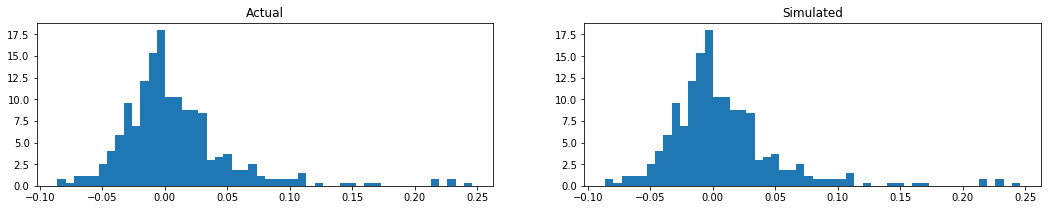

In [10]:
fig = plt.figure(figsize=(18,3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.hist(returns, bins=50, density=True)
ax2.hist(simulated_returns.values.flatten(), bins=50, density=True)
ax1.set_title('Actual')
ax2.set_title('Simulated')
plt.show();

# Stats for actual returns

In [11]:
a=perf_stats(returns)
a

Annual return           4.529899
Cumulative returns     15.268085
Annual volatility       0.704368
Sharpe ratio            2.767247
Calmar ratio           19.178639
Stability               0.963792
Max drawdown           -0.236195
Omega ratio             1.719645
Sortino ratio           6.263173
Skew                    1.993861
Kurtosis                6.997923
Tail ratio              1.924605
Daily value at risk    -0.081007
dtype: float64

# Stats for simulated returns (median, max, min)

In [12]:
ratios_for_paths = pd.DataFrame([perf_stats(x[1]) for x in simulated_returns.T.iterrows()])

median

In [13]:
ratios_for_paths.median().T

Annual return           4.495136
Cumulative returns     15.101623
Annual volatility       0.701071
Sharpe ratio            2.771265
Calmar ratio           15.019541
Stability               0.937465
Max drawdown           -0.299463
Omega ratio             1.718181
Sortino ratio           6.254892
Skew                    1.966424
Kurtosis                6.739947
Tail ratio              1.893059
Daily value at risk    -0.080623
dtype: float64

max

In [14]:
ratios_for_paths.max().T

Annual return            78.432076
Cumulative returns     1254.459941
Annual volatility         0.942095
Sharpe ratio              5.587606
Calmar ratio            419.336954
Stability                 0.995957
Max drawdown             -0.116254
Omega ratio               3.262502
Sortino ratio            17.575548
Skew                      3.031856
Kurtosis                 14.419579
Tail ratio                3.999038
Daily value at risk      -0.056472
dtype: float64

min

In [15]:
ratios_for_paths.min().T

Annual return         -0.464592
Cumulative returns    -0.639008
Annual volatility      0.480952
Sharpe ratio          -0.828016
Calmar ratio          -0.661749
Stability              0.000004
Max drawdown          -0.786367
Omega ratio            0.866415
Sortino ratio         -1.280485
Skew                   0.389266
Kurtosis               0.241132
Tail ratio             0.975809
Daily value at risk   -0.103869
dtype: float64

# Probability that max drawdown less than x

In [28]:
x = -.4
len(ratios_for_paths[ratios_for_paths['Max drawdown'] < x]) / number_of_paths

0.134698

# Probability that Sharpe lower than y

In [17]:
y = 1
len(ratios_for_paths[ratios_for_paths['Sharpe ratio'] < y]) / number_of_paths

0.006448

# Probability that annual return less than z

In [18]:
z = 2
len(ratios_for_paths[ratios_for_paths['Annual return'] < z]) / number_of_paths

0.121302

# Distributions

Max drawdown

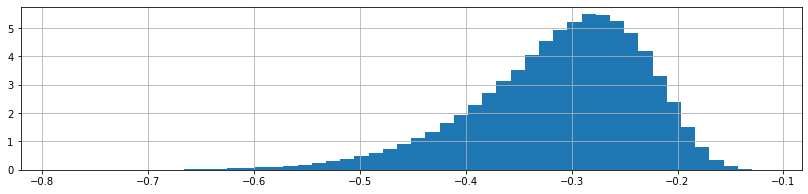

In [19]:
ratios_for_paths['Max drawdown'].hist(bins=50, figsize=(14,3), density=True);

Sharpe

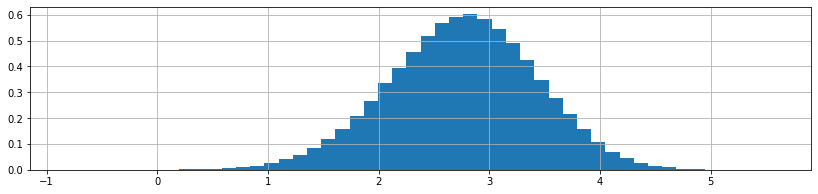

In [20]:
ratios_for_paths['Sharpe ratio'].hist(bins=50, figsize=(14,3), density=True);

Annual return

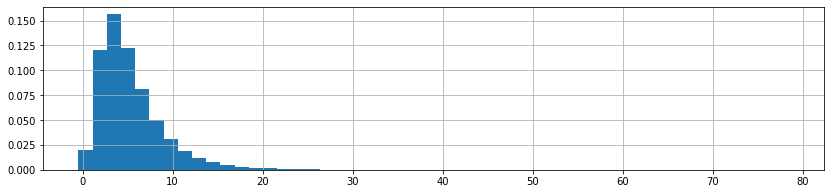

In [21]:
ratios_for_paths['Annual return'].hist(bins=50, figsize=(14,3), density=True);